# Project 2

## Setup 

Download the data from the worldbank

In [1]:
# download and update the data in the project
!./setup.sh 

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘report/data’: File exists
mkdir: cannot create directory ‘report/images’: File exists
--2024-09-29 04:08:31--  https://archive.ics.uci.edu/static/public/2/adult.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.zip’

adult.zip               [       <=>          ] 605.70K   201KB/s    in 3.0s    

2024-09-29 04:08:37 (201 KB/s) - ‘adult.zip’ saved [620237]

Archive:  adult.zip


In [2]:
!pip install -r requirements.txt

In [3]:
import pandas as pd
import scipy.stats as stats
from scipy.stats import shapiro
from scipy.stats import kruskal
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms

import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix

file_output = "report/data"
image_output = "report/images"

In [4]:
education_level_labels = [
    "Grade R/0",
    "Grade 1/Sub A/Class 1",
    "Grade 2/Sub B/Class 2",
    "Grade 3/Standard 1/ABET/AET 1",
    "Grade 4/Standard 2",
    "Grade 5/Standard 3/ABET/AET 2",
    "Grade 6/Standard 4",
    "Grade 7/Standard 5/ABET/AET 3",
    "Grade 8/Standard 6/Form 1",
    "Grade 9/Standard 7/Form 2/ABET/AET 4/NCV Level 1/OCCUPATIONAL CERTIFICATE - NQF LEVEL 1",
    "Grade 10/Standard 8/Form 3/NCV Level 2/OCCUPATIONAL CERTIFICATE – NQF LEVEL 2",
    "Grade 11/Standard 9/Form 4/NCV Level 3/OCCUPATIONAL CERTIFICATE – NQF LEVEL 3",
    "Grade 12/Standard 10/Form 5/National Senior Certificate/Matric/NCV Level 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 4",
    "NTC L/N1/NQF 1",
    "NTC LL/N2/NQF 2",
    "NTC LLL/N3/NQF 3",
    "N4/NTC 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "N5/NTC 5/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "N6/NTC 6/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "Certificate with Less Than Grade 12/Standard 10",
    "Diploma with Less Than Grade 12/Standard 10",
    "Higher/National/Advance Certificate with Grade 12/Std 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5",
    "Diploma with Grade 12/Standard 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 6",
    "Higher Diploma/OCCUPATIONAL CERTIFICATE (B-Tech Diploma) – NQF LEVEL 7",
    "Bachelor’s Degree/OCCUPATIONAL CERTIFICATE – NQF LEVEL 7",
    "Honours Degree/Postgraduate Diploma/OCCUPATIONAL CERTIFICATE – NQF LEVEL 8",
    "Post Higher Diploma (M-Tech and Master's Degree) – NQF LEVEL 9",
    "Doctoral Degrees (D-Tech and PhD) – NQF LEVEL 10",
    "Other Than Any of the Above",
    "Do Not Know",
]

other_education_labels = {
    98: "No Schooling",
    99: "Unspecified"
}

employment_labels = {
    1: "Employed",
    2: "Unemployed",
    3: "Not economically active",
    8: "Not applicable"
}

education_bins = {
    0: "No Formal Education",
    1: "Basic Education",
    2: "Intermediate Education",
    3: "Secondary Education",
    4: "Vocational Education",
    5: "Tertiary Education",
}
bin_mapping = {
    "No Schooling": 0,
    "Grade R/0": 1,
    "Grade 1/Sub A/Class 1": 1,
    "Grade 2/Sub B/Class 2": 1,
    "Grade 3/Standard 1/ABET/AET 1": 1,
    "Grade 4/Standard 2": 2,
    "Grade 5/Standard 3/ABET/AET 2": 2,
    "Grade 6/Standard 4": 2,
    "Grade 7/Standard 5/ABET/AET 3": 2,
    "Grade 8/Standard 6/Form 1": 2,
    "Grade 9/Standard 7/Form 2/ABET/AET 4/NCV Level 1/OCCUPATIONAL CERTIFICATE - NQF LEVEL 1": 3,
    "Grade 10/Standard 8/Form 3/NCV Level 2/OCCUPATIONAL CERTIFICATE – NQF LEVEL 2": 3,
    "Grade 11/Standard 9/Form 4/NCV Level 3/OCCUPATIONAL CERTIFICATE – NQF LEVEL 3": 3,
    "Grade 12/Standard 10/Form 5/National Senior Certificate/Matric/NCV Level 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 4": 3,
    "NTC L/N1/NQF 1": 4,
    "NTC LL/N2/NQF 2": 4,
    "NTC LLL/N3/NQF 3": 4,
    "N4/NTC 4/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 4,
    "N5/NTC 5/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 4,
    "N6/NTC 6/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 4,
    "Certificate with Less Than Grade 12/Standard 10": 3,
    "Diploma with Less Than Grade 12/Standard 10": 3,
    "Higher/National/Advance Certificate with Grade 12/Std 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 5": 5,
    "Diploma with Grade 12/Standard 10/OCCUPATIONAL CERTIFICATE – NQF LEVEL 6": 5,
    "Higher Diploma/OCCUPATIONAL CERTIFICATE (B-Tech Diploma) – NQF LEVEL 7": 5,
    "Bachelor’s Degree/OCCUPATIONAL CERTIFICATE – NQF LEVEL 7": 5,
    "Honours Degree/Postgraduate Diploma/OCCUPATIONAL CERTIFICATE – NQF LEVEL 8": 5,
    "Post Higher Diploma (M-Tech and Master's Degree) – NQF LEVEL 9": 5,
    "Doctoral Degrees (D-Tech and PhD) – NQF LEVEL 10": 5,
}


In [5]:
df = pd.read_csv("data/GHS-2023-PERSON_F1.csv")
print(df.isnull().sum())

columns_to_convert = ['psu','employ_Status2','lab_amount','lab_sto', 'prov', 'Sex', 'age', 'age_grp1', 'hhc_relationship']  # Add more as needed
df[columns_to_convert] = df[columns_to_convert].apply(pd.to_numeric, errors='coerce')

df["education-name"] = df['education'].map(lambda x: education_level_labels[x] if x < len(education_level_labels) else other_education_labels[x] if x in other_education_labels.keys() else None)

sex_mapping = {1: 'Male', 2: 'Female'}
df['Sex'] = df['Sex'].map(sex_mapping)
df = df.dropna()

uqnr              0
personnr          0
psu               0
prov              0
Four_by_Four      0
                 ..
lab_salary        0
employ_Status1    0
employ_Status2    0
rotation          0
person_wgt        0
Length: 112, dtype: int64


**Hypothesis 1: Does Education Level Affect Income?**
 - **Null Hypothesis (H₀)**: Education level does not significantly affect the likelihood of earning more than $50K per year.
 - **Alternative Hypothesis (H₁)**: Education level significantly affects the likelihood of earning more than $50K per year.
    
To test this hypothesis, we performed a chi-square test of independence. Since both education level and income are categorical variables, the chi-square test is appropriate to evaluate whether there is a statistically significant association between these variables. Additionally, a logistic regression model was used to assess the predictive power of education level on income.

In [6]:
#clean and prepare data

# filter the data by those who were willing to disclose their earnings
income_data = df[(df['employ_Status2'] <= 2) & (df['education'] != 29) & (df['education'] != 99 )]
# income_data
income_data['education_category'] = income_data['education-name'].map(bin_mapping)

/tmp/ipykernel_65414/3971188269.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_data['education_category'] = income_data['education-name'].map(bin_mapping)


In [7]:
print(income_data.groupby(['education_category', 'employ_Status2'])['uqnr'].count())
print(income_data.groupby(['age', 'employ_Status2'])['uqnr'].count())

education_category  employ_Status2
0.0                 1                   230
                    2                    97
1.0                 1                   209
                    2                   107
2.0                 1                  1920
                    2                  1174
3.0                 1                 12336
                    2                  7749
4.0                 1                   450
                    2                   227
5.0                 1                  3705
                    2                   649
Name: uqnr, dtype: int64
age  employ_Status2
15   1                  3
     2                 19
16   1                  4
     2                 22
17   1                 10
                       ..
80   1                  4
81   1                  1
82   1                  4
83   1                  1
89   1                  2
Name: uqnr, Length: 129, dtype: int64


In [8]:
# # create a contingency table between education and income
contingency_table = pd.crosstab(income_data['education_category'], income_data['employ_Status2'])
# contingency_table.columns = ['<=50K', '>50K']

# with open(f"{file_output}/hyp1_cont_table.tex", "w") as f:
#     latex_table = contingency_table.to_latex()
#     f.write(latex_table)

contingency_table

employ_Status2,1,2
education_category,,
0.0,230,97
1.0,209,107
2.0,1920,1174
3.0,12336,7749
4.0,450,227
5.0,3705,649


In [9]:
# perform chi squared
chi2 = stats.chi2_contingency(contingency_table)

# save results as latex table
with open(f"{file_output}/hyp_1_chi_2.tex", "w") as f:
    res = pd.DataFrame({
        r'$\chi^2': {"Value": r'{:.2f}'.format(chi2.statistic)},
        r'$p$': {"Value": r'{:.2f}'.format(chi2.pvalue)}
    })
    f.write(res.to_latex())
    # Conclusion based on the p-value

print(f"Chi-square statistic: {chi2.statistic:.2f}")
print(f"P-value: {chi2.pvalue:.4f}")

alpha = 0.05
if chi2.pvalue < alpha:
    print("Reject the null hypothesis (H₀): Education level significantly affects the likelihood being employed.")
else:
    print("Fail to reject the null hypothesis (H₀): Education level does not significantly affect the likelihood of being employed.")

Chi-square statistic: 905.29
P-value: 0.0000
Reject the null hypothesis (H₀): Education level significantly affects the likelihood being employed.


In [10]:
income_data = income_data.dropna(subset=['education_category', 'employ_Status2'])
print(income_data.groupby(['education_category'])['employ_Status2'].count())
le = LabelEncoder()
# df['income-binary'] = le.fit_transform(df['income-binary'])
# df['education-num'] = le.fit_transform(df['education-num'])
# Logistic regression with education as the independent variable and income as the dependent variable
X = sm.add_constant(income_data['education_category'])  # Add constant term
y = income_data['employ_Status2'] - 1 


# Fit logistic regression model
model = sm.Logit(y, X)
result = model.fit()

# Summary of the model
print(result.summary())

with open(f"{file_output}/hyp_1_log_summary.tex", "w") as f:
    f.write(result.summary().as_latex())

education_category
0.0      327
1.0      316
2.0     3094
3.0    20085
4.0      677
5.0     4354
Name: employ_Status2, dtype: int64
Optimization terminated successfully.
         Current function value: 0.635305
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:         employ_Status2   No. Observations:                28853
Model:                          Logit   Df Residuals:                    28851
Method:                           MLE   Df Model:                            1
Date:                Sun, 29 Sep 2024   Pseudo R-squ.:                 0.01560
Time:                        04:08:42   Log-Likelihood:                -18330.
converged:                       True   LL-Null:                       -18621.
Covariance Type:            nonrobust   LLR p-value:                2.302e-128
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------

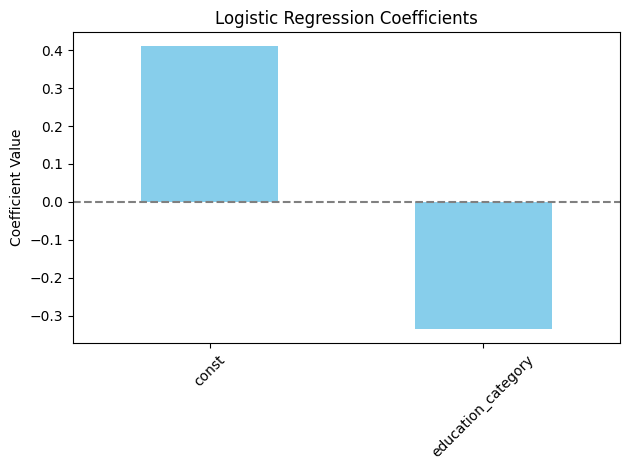

In [11]:
import matplotlib.pyplot as plt

# Prepare the coefficients for plotting
coef = result.params
coef.plot(kind='bar', color='skyblue')
plt.title('Logistic Regression Coefficients')
plt.ylabel('Coefficient Value')
plt.axhline(0, color='gray', linestyle='--')  # Reference line at 0
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f"{image_output}/hyp_1_log_coeff.svg", format="svg")
plt.show()



/tmp/ipykernel_65414/1473822193.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='education_category', y='predicted_prob', data=sorted_vals, ci=None, palette='Set2')
/tmp/ipykernel_65414/1473822193.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='education_category', y='predicted_prob', data=sorted_vals, ci=None, palette='Set2')


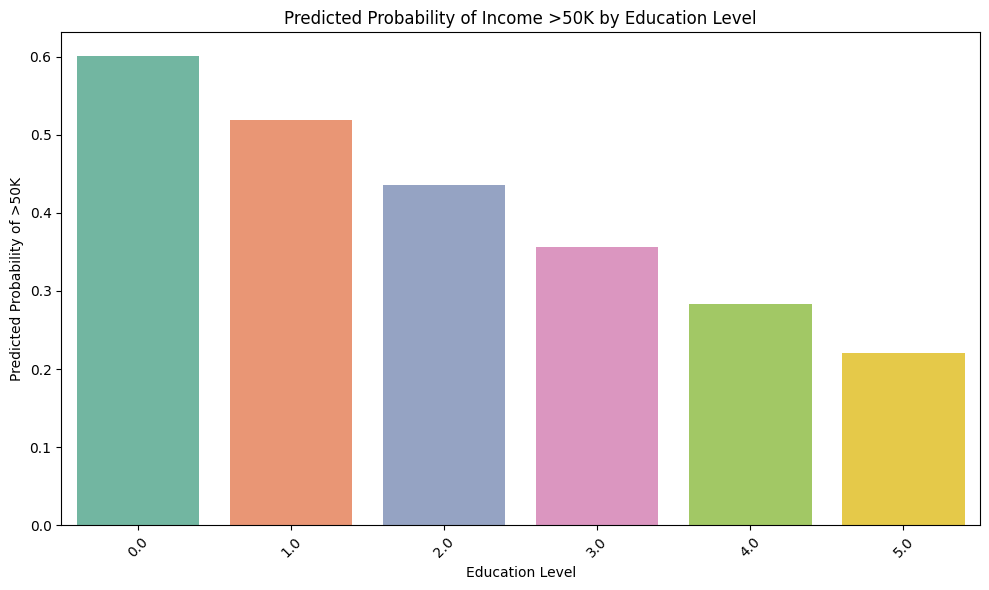

/tmp/ipykernel_65414/1473822193.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


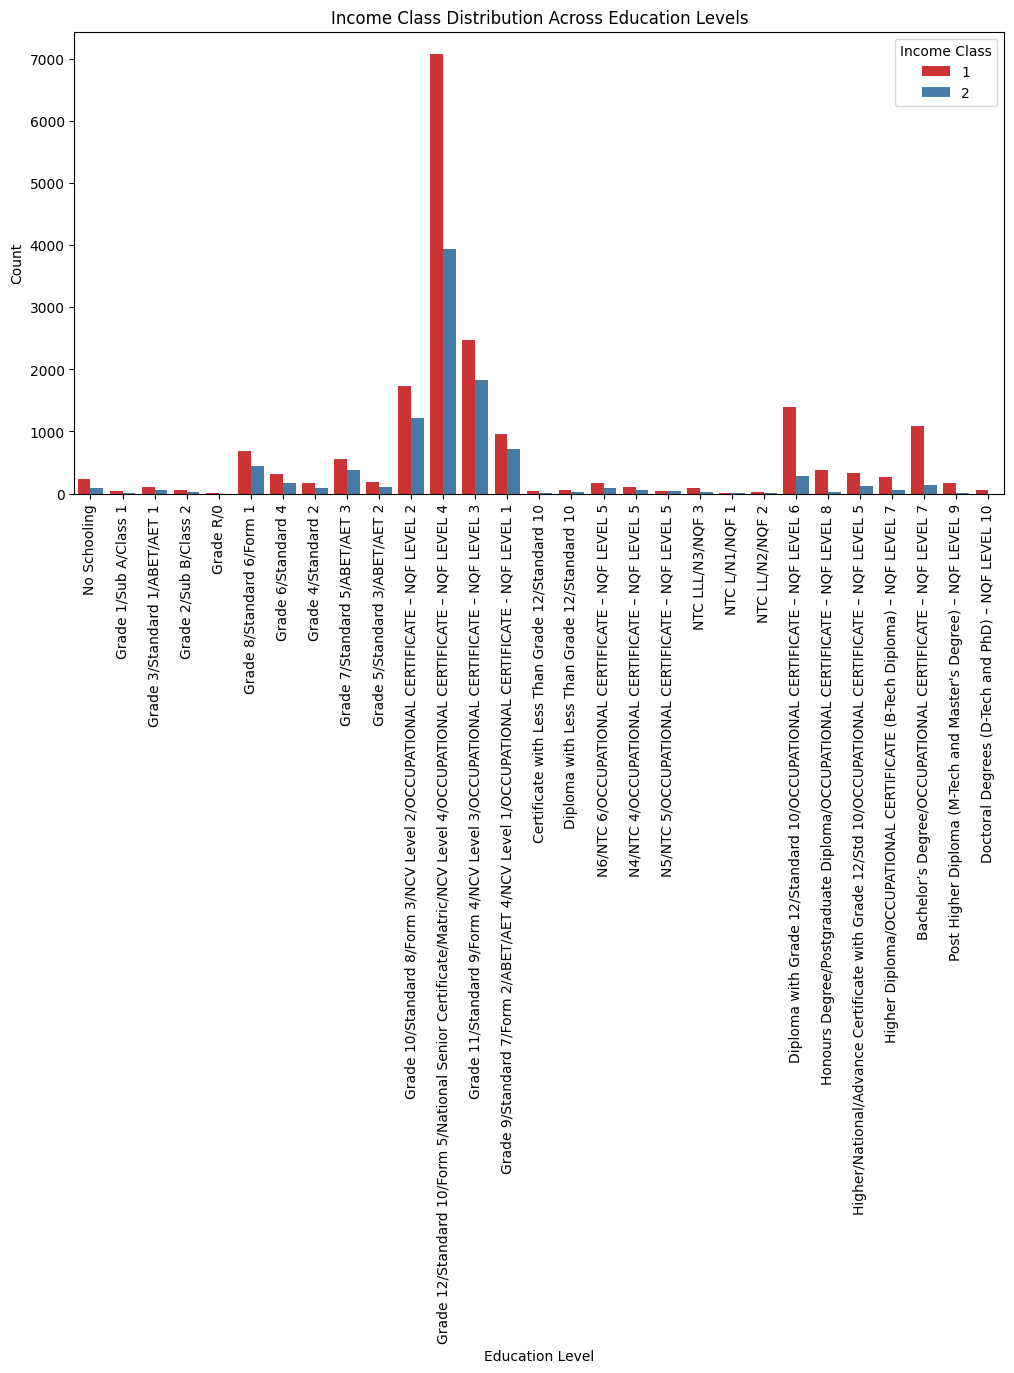

In [12]:
# Prepare the data for plotting

income_data['predicted_prob'] = result.predict(X)
sorted_vals = income_data.sort_values(by='education_category', ascending=True)


plt.figure(figsize=(10, 6))
sns.barplot(x='education_category', y='predicted_prob', data=sorted_vals, ci=None, palette='Set2')
plt.title('Predicted Probability of Income >50K by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Predicted Probability of >50K')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{image_output}/hyp_1_log_pred.svg", format="svg")
plt.show()

# Assuming df contains the 'income' and 'education_level' columns
plt.figure(figsize=(12, 6))

# Create a count plot
sns.countplot(data=sorted_vals, x='education-name', hue='employ_Status2', palette='Set1')

# Customize the plot
plt.title('Income Class Distribution Across Education Levels')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.legend(title='Income Class', loc='upper right')

plt.tight_layout()
plt.savefig(f"{image_output}/hyp_1_income_dist.svg", format="svg")
plt.show()

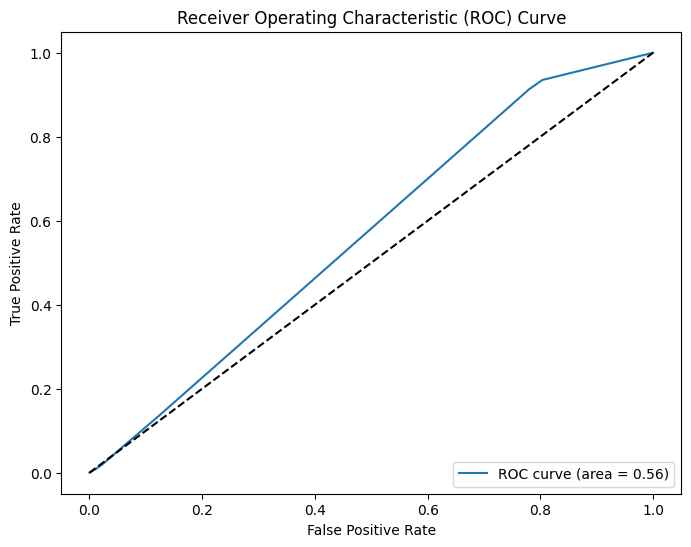

In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, income_data['predicted_prob'])
roc_auc = roc_auc_score(y, income_data['predicted_prob'])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()


In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Select the relevant features for clustering
X = df[['education-num', 'hours-per-week']]

# Scale the data (important for K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

cluster_range = range(2, 11)
inertia = []
sil_scores = []
ch_scores = []

for i in cluster_range:
    kmeans = KMeans(n_clusters=i, random_state=42)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Inertia (within-cluster sum of squares)
    inertia.append(kmeans.inertia_)
    
    # Silhouette Score
    sil_scores.append(silhouette_score(X_scaled, cluster_labels))
    
    # Calinski-Harabasz Index
    ch_scores.append(calinski_harabasz_score(X_scaled, cluster_labels))

# Plot the Elbow Curve (Inertia)
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, 'bo-', label='Inertia (Elbow Method)')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal Clusters')
plt.show()

# Plot the Silhouette Score
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, sil_scores, 'ro-', label='Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal Clusters')
plt.show()

# Plot the Calinski-Harabasz Index
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, ch_scores, 'go-', label='Calinski-Harabasz Index')
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index For Optimal Clusters')
plt.show()

KeyError: "None of [Index(['education-num', 'hours-per-week'], dtype='object')] are in the [columns]"

In [ ]:
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the dataframe
df['cluster'] = kmeans.labels_

cluster_summary = df.groupby('cluster')[['education-num', 'hours-per-week']].mean()
print(cluster_summary)

cluster_2 = df[(df['cluster'] == 2) & (df['income-binary'] == 1)]
print(cluster_2[['education-num', 'hours-per-week', 'income-binary']].head())

cluster_1 = df[(df['cluster'] == 1) & (df['income-binary'] == 1)]
print(cluster_1[['education-num', 'hours-per-week', 'income-binary']].head())


cluster_0 = df[(df['cluster'] == 0) & (df['income-binary'] == 1)]
print(cluster_0[['education-num', 'hours-per-week', 'income-binary']].head())

# Scatter plot of education vs hours worked, colored by cluster
plt.figure(figsize=(10, 6))
sns.scatterplot(x='education-num', y='hours-per-week', hue='cluster', data=df, palette='Set2')

# Highlight Cluster 2 (highly educated individuals working fewer hours)
# sns.scatterplot(x='education-num', y='hours-per-week', data=cluster_2, color='red', label='Cluster 2 (>50K)')
plt.title('Clusters of Education vs Hours Worked')
plt.xlabel('Years of Education')
plt.ylabel('Hours per Week')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Select relevant features for clustering
features = ['age', 'education-num', 'hours-per-week', 'capital-gain']
X_clustering = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)


silhouette_scores = []
calinski_harabasz_scores = []

cluster_range = range(2,10)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X_scaled)

    silhouette_avg = silhouette_score(X_scaled, labels)
    silhouette_scores.append(silhouette_avg)

    calinski_harabasz_avg = calinski_harabasz_score(X_scaled, labels)
    calinski_harabasz_scores.append(calinski_harabasz_avg)

    # Visualize the reduced dimensions
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='Set1')
    plt.title('PCA of Clusters')
    plt.show()


# Plotting the results
plt.figure(figsize=(12, 6))

# Plot Silhouette Scores
plt.subplot(1, 2, 1)
plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different Cluster Sizes')
plt.grid(True)

# Plot Calinski-Harabasz Index
plt.subplot(1, 2, 2)
plt.plot(cluster_range, calinski_harabasz_scores, marker='o', color='orange', label='Calinski-Harabasz Index')
plt.xlabel('Number of Clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for Different Cluster Sizes')
plt.grid(True)

plt.tight_layout()
plt.show()

Does education level affect the salary

In [38]:
income_data = income_data[(income_data['lab_amount'] == 1) & (income_data['lab_salary'] < 88888888)]
income_data['lab_salary'].describe()


       age  lab_salary
66185   58      160000
563     46      200000
64334   39      250000
19782   33      250000
39216   76      250000
582     51      250000
53042   54      450000
29800   37      450000
5799    42      450000
44969   41     1900000


In [56]:
def Test_normally_distributed(group1, name):
    ks_eval = stats.kstest(group1, 'norm', args=(np.mean(group1), np.std(group1)))
    print(f"Kolmogorov-Smirnov Test for {name}: W={ks_eval[0]}, p-value={ks_eval[1]}")

    with open(f"{file_output}/hyp_2_norm_dist_{name}.tex", "w") as f:
        res = pd.DataFrame({
            r"W": {"Value": ks_eval[0]},
            r"$p$": {"Value": ks_eval[1]}
        })
        f.write(res.to_latex())

    if ks_eval.pvalue > 0.05:
        print(f"The data is not normally distributed")
    else:
        print("The data is normally distributed")

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    stats.probplot(group1, dist="norm", plot=plt)
    plt.title(f'Q-Q Plot for {name}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(group1, kde=True)
    plt.title(f'Hours Worked by {name} with KDE')

    plt.tight_layout()
    plt.savefig(f"{image_output}/hyp_2_norm_dist_{name}.svg", format='svg')
    plt.show()

In [69]:
income_data = income_data[(income_data['lab_amount'] == 1) & (income_data['lab_salary'] < 88888888)]
income_data['education_category'] = income_data['education_category'].astype('category')

income_data.groupby('education_category').violinplot(column="lab_salary", sharey=False)
Test_normally_distributed(income_data["lab_salary"], "income data")

anova_model = ols('lab_salary ~ C(education_category)', data=income_data).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

anova_table

/tmp/ipykernel_61887/3287232906.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  income_data.groupby('education_category').violinplot(column="lab_salary", sharey=False)


AttributeError: 'DataFrameGroupBy' object has no attribute 'violinplot'

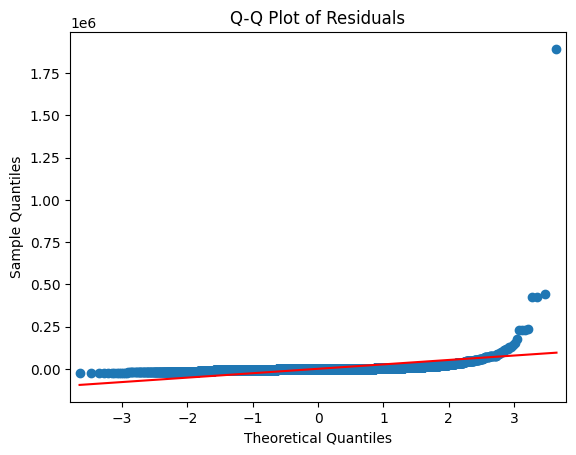

In [16]:
sm.qqplot(anova_model.resid, line='s')
plt.title("Q-Q Plot of Residuals")
plt.show()

In [17]:
shapiro_test = shapiro(anova_model.resid)

print("Shapiro-Wilk Test:")
print(f"Statistic: {shapiro_test.statistic}, p-value: {shapiro_test.pvalue}")

Shapiro-Wilk Test:
Statistic: 0.14879673748683886, p-value: 2.438343292962968e-103


/home/ciaranotter/School/Datasci/Project_2/.venv/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7596.
  res = hypotest_fun_out(*samples, **kwds)


In [52]:
from scipy.stats import levene
# Perform Levene's test
levene_test = levene(
                    # income_data['lab_salary'][income_data['education_category'] == 0], 
                     income_data['lab_salary'][income_data['education_category'] == 1],
                    #  income_data['lab_salary'][income_data['education_category'] == 2],
                     income_data['lab_salary'][income_data['education_category'] == 3],
                    #  income_data['lab_salary'][income_data['education_category'] == 4],
                     income_data['lab_salary'][income_data['education_category'] == 5]
                    ) # Add more groups if necessary

print("Levene's Test for Homogeneity of Variances:")
print(f"Statistic: {levene_test.statistic}, p-value: {levene_test.pvalue}")

Levene's Test for Homogeneity of Variances:
Statistic: 62.75508212877916, p-value: 1.049722265531398e-27


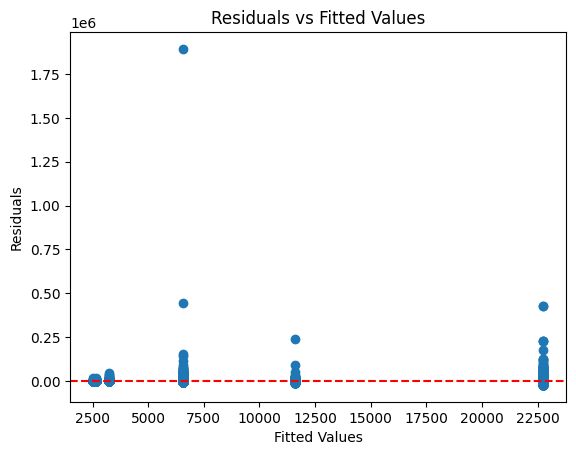

In [22]:
# Residual plot to check for patterns
plt.scatter(anova_model.fittedvalues, anova_model.resid)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.show()

In [77]:
groups = [group['lab_salary'].values for name, group in income_data.groupby('education_category', observed=False)]
kruskal_statistic, kruskal_p_value = kruskal(*groups)

print(kruskal_statistic)
kruskal_p_value

1709.889302020338


np.float64(0.0)

In [78]:
_, p_value_levene = levene(*groups)
if p_value_levene < 0.05:
    print("Groups have unequal variances (reject H0 of Levene's test)")

Groups have unequal variances (reject H0 of Levene's test)


In [94]:
from scipy.stats import welch_anova
from scipy.stats import welch_anova
welch_statistic, welch_p_value = f_oneway(*groups, equal_var=False)

print(f"Welch's ANOVA statistic: {welch_statistic}, p-value: {welch_p_value}")

ImportError: cannot import name 'welch_anova' from 'scipy.stats' (/home/ciaranotter/School/Datasci/Project_2/.venv/lib/python3.12/site-packages/scipy/stats/__init__.py)

**Hypothesis 2: Highest education level Affect Hours Worked per Week?**
    
 - **Null Hypothesis ($H_0$)**: There is no significant difference in the number of hours worked per week between men and women.
 - **Alternative Hypothesis ($H_1$)**: There is a significant difference in the number of hours worked per week between men and women.
    
An independent t-test was employed to compare the mean hours worked by men and women. This test is suitable because it compares the means of two independent groups, assuming the hours worked are normally distributed within each group.

In [93]:
welch_statistic, df_num, df_den = welch_anova(*groups)
print(f"Welch's ANOVA statistic: {welch_statistic}, df_num: {df_num}, df_den: {df_den}")


NameError: name 'welch_anova' is not defined

Kolmogorov-Smirnov Test for men: W=0.24968466158264074, p-value=0.0
The data is normally distributed


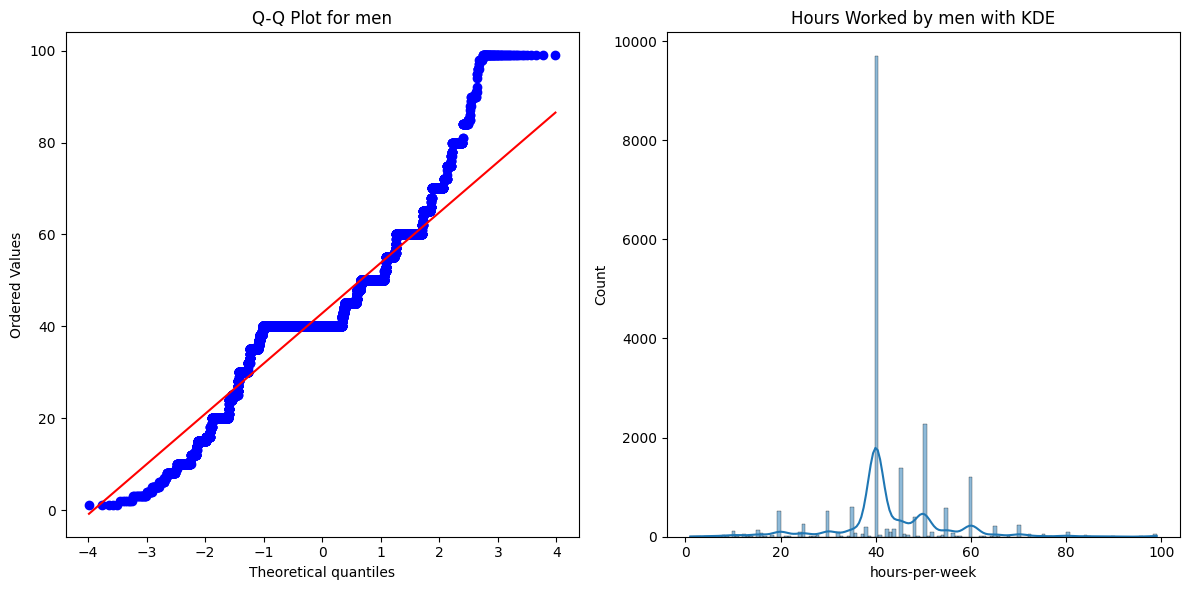

Kolmogorov-Smirnov Test for women: W=0.2372517385415961, p-value=0.0
The data is normally distributed


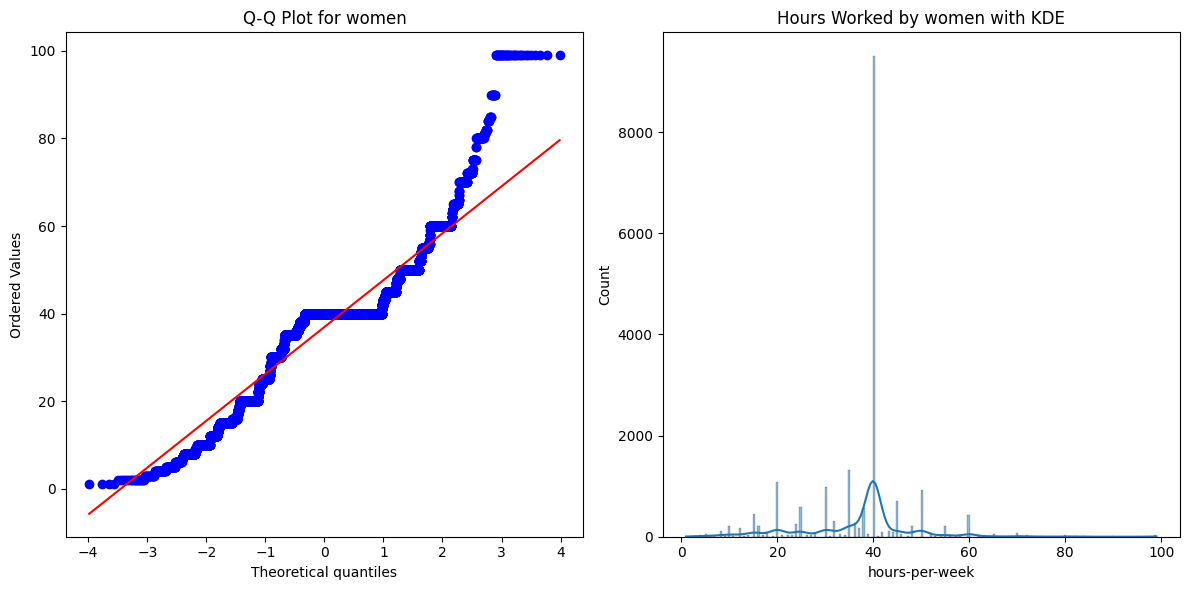

T-statistic: 51.45410153333287
P-value: 0.0
Reject the null hypothesis (H₀): There is a significant difference in hours worked between men and women.


In [37]:
from sklearn.utils import resample

# Separate majority and minority classes
df_male = df[df['sex'] == 'Male']
df_female = df[df['sex'] == 'Female']

# Upsample minority class
df_female_upsampled = resample(df_female, 
                                replace=True,  # sample with replacement
                                n_samples=len(df_male),  # to match majority class
                                random_state=123)  # reproducible results

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_male, df_female_upsampled])

from scipy.stats import ttest_ind

# Split data into two groups: Male and Female
men = df_balanced[df_balanced['sex'] == 'Male']['hours-per-week']
women = df_balanced[df_balanced['sex'] == 'Female']['hours-per-week']

# 1. Shapiro-Wilk Test
Test_normally_distributed(men, "men")
Test_normally_distributed(women, "women")

# Perform the Mann-Whitney U Test
t_stat, p_val = ttest_ind(men, women, equal_var=False)

print(f'T-statistic: {t_stat}')
print(f'P-value: {p_val}')

with open(f"{file_output}/hyp_2_t-test.tex", "w") as f:
    res = pd.DataFrame({
        "T-statistic": {"Value": f'{t_stat:.2f}'},
        r"$p$": {"Value": f'{p_val:.2f}'}
    })

    f.write(res.to_latex())
# Conclusion based on the p-value
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis (H₀): There is a significant difference in hours worked between men and women.")
else:
    print("Fail to reject the null hypothesis (H₀): There is no significant difference in hours worked between men and women.")


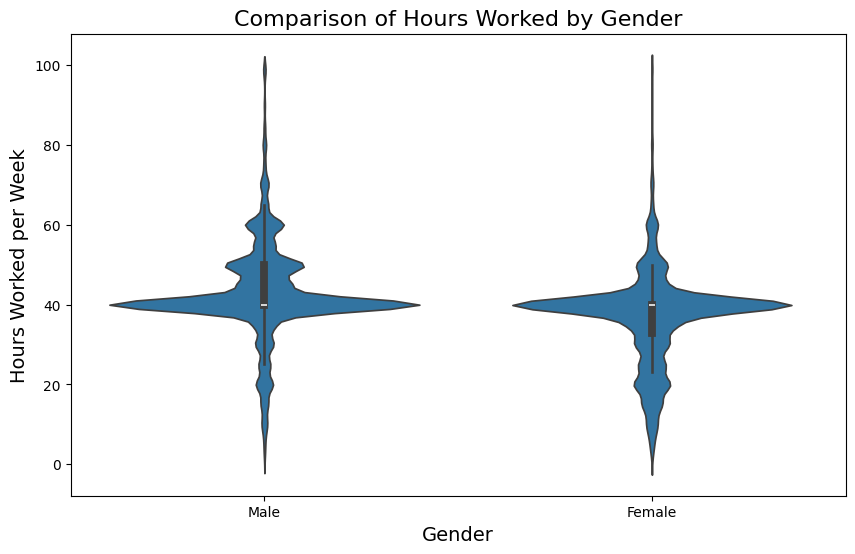

In [38]:
# Assuming your dataframe is named 'df' and has columns 'hours-per-week' and 'gender'
plt.figure(figsize=(10, 6))

# Create a box plot for hours worked by gender
sns.violinplot(x='sex', y='hours-per-week', data=df)


# Add title and labels
plt.title('Comparison of Hours Worked by Gender', fontsize=16)
plt.xlabel('Gender', fontsize=14)
plt.ylabel('Hours Worked per Week', fontsize=14)

plt.savefig(f"{image_output}/hyp_2_violin_plot.svg", format="svg")
# Show plot
plt.show()

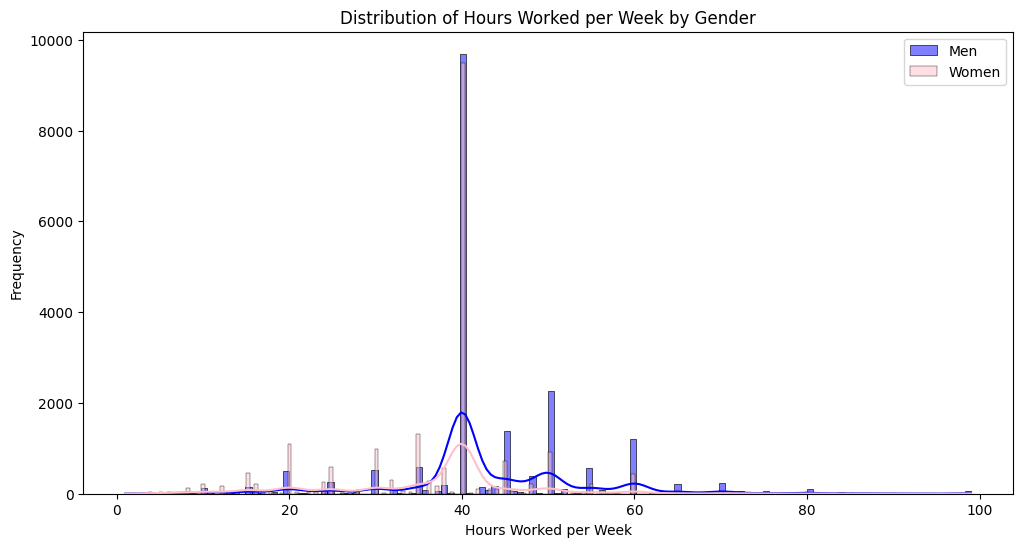

In [39]:
plt.figure(figsize=(12, 6))

# Histogram with KDE for Men
sns.histplot(df_balanced[df_balanced['sex'] == 'Male']['hours-per-week'], kde=True, color='blue', label='Men')
# Histogram with KDE for Women
sns.histplot(df_balanced[df_balanced['sex'] == 'Female']['hours-per-week'], kde=True, color='pink', label='Women')

plt.title('Distribution of Hours Worked per Week by Gender')
plt.xlabel('Hours Worked per Week')
plt.ylabel('Frequency')
plt.legend()
plt.show()

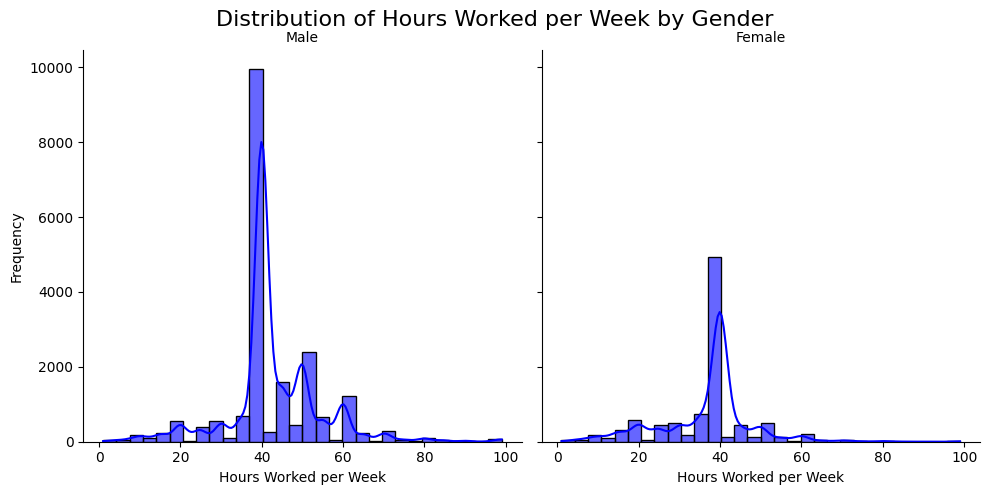

In [26]:
g = sns.FacetGrid(df, col='sex', height=5, aspect=1)
g.map(sns.histplot, 'hours-per-week', kde=True, bins=30, color='blue', alpha=0.6)
g.set_axis_labels('Hours Worked per Week', 'Frequency')
g.set_titles(col_template="{col_name}")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Distribution of Hours Worked per Week by Gender', fontsize=16)
plt.show()

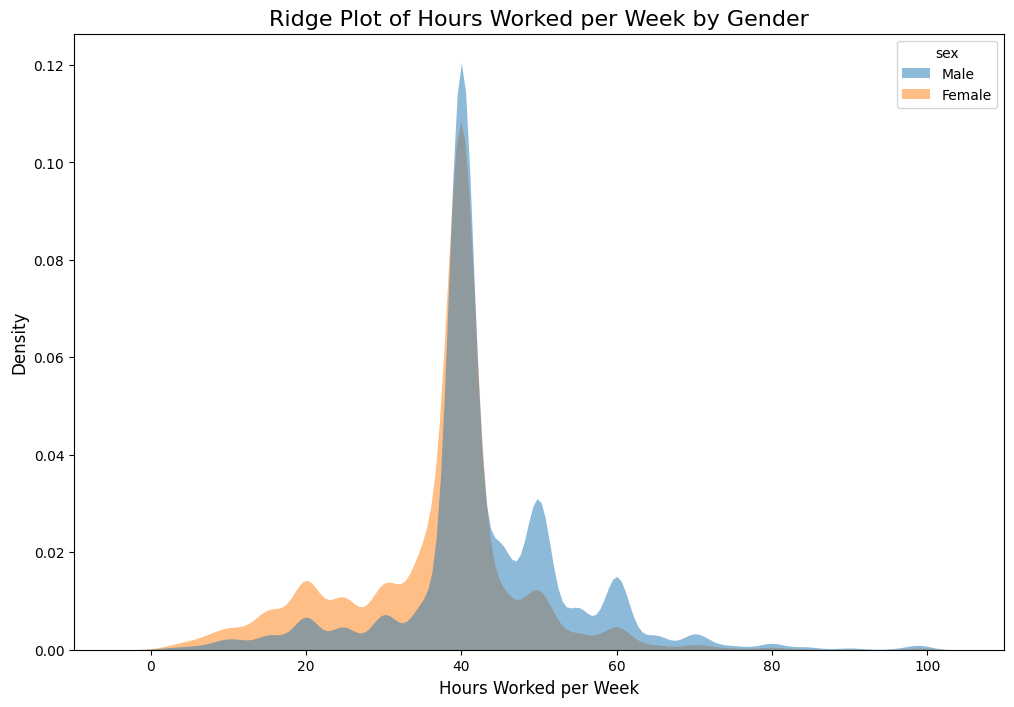

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(12, 8))

# Create the ridge plot using sns.kdeplot
sns.kdeplot(data=df, x='hours-per-week', hue='sex', fill=True, common_norm=False, alpha=0.5, linewidth=0)

# Add titles and labels
plt.title('Ridge Plot of Hours Worked per Week by Gender', fontsize=16)
plt.xlabel('Hours Worked per Week', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

In [35]:
summary = df.groupby('sex')['hours-per-week'].describe()
with open(f"{file_output}/hyp_2_data_desc.tex", "w") as f:
    f.write(summary.to_latex(float_format="%.2f"))
summary

,count,mean,std,min,25%,50%,75%,max
sex,,,,,,,,
Female,9782.0,36.932222,11.429769,1.0,33.0,40.0,40.0,99.0
Male,20380.0,42.850687,11.762157,1.0,40.0,40.0,50.0,99.0


In [31]:
# Using weights to balance representation in a histogram
plt.figure(figsize=(12, 6))
sns.histplot(df['hours-per-week'], hue='sex', weights=df['sex'].value_counts(normalize=True), kde=True, bins=30)
plt.title('Weighted Distribution of Hours Worked per Week by Gender', fontsize=16)
plt.xlabel('Hours Worked per Week', fontsize=12)
plt.ylabel('Weighted Frequency', fontsize=12)
plt.show()

ValueError: The following variables cannot be assigned with wide-form data: `hue`, `weights`

<Figure size 1200x600 with 0 Axes>

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# Select relevant features
features = ['age', 'hours-per-week', 'education-num']
X_dbscan = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled_dbscan = scaler.fit_transform(X_dbscan)

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
df['dbscan_cluster'] = dbscan.fit_predict(X_scaled_dbscan)

# Visualize DBSCAN clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='hours-per-week', hue='dbscan_cluster', data=df, palette='Set1')
plt.title('DBSCAN Clusters: Age vs Hours Worked per Week')
plt.show()

# Evaluate clustering
unique_clusters = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
print(f'Number of clusters: {unique_clusters}')

In [ ]:
import statsmodels.api as sm
from sklearn.preprocessing import LabelEncoder

# Encode race as a numerical variable
le_race = LabelEncoder()
df['race_num'] = le_race.fit_transform(df['race'])

# Logistic regression: race as independent variable, income as dependent
X_race = sm.add_constant(df['race_num'])
y_income = df['income']

# Fit logistic regression model
logit_model = sm.Logit(y_income, X_race)
logit_result = logit_model.fit()

# Output summary of logistic regression results
print(logit_result.summary())

# Interpretation based on p-values and coefficients

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

# Select relevant features for clustering
features = ['age', 'education-num', 'capital-loss', 'hours-per-week', 'capital-gain']
X_clustering = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clustering)

kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Assuming `kmeans_labels` is the result of K-Means clustering
# and `X` is your feature set (e.g., 'hours_per_week', 'education_level')

# Apply PCA to reduce data to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Scatter plot with clusters
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['income'], cmap='viridis')

plt.title('K-Means Clustering with Income')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Income (<=50K=0, >50K=1)')
plt.show()

In [ ]:
# Convert income to binary (0 for <=50K, 1 for >50K)
df['income_binary'] = df['income'].map({'<=50K': 0, '>50K': 1})

plt.figure(figsize=(8, 6))

# Create heatmap of correlations
sns.heatmap(df[['income_binary', 'hours-per-week', 'education-num']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap with Binary Income')
plt.show()

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select relevant features
features = ['age', 'capital-gain','capital-loss' ,'hours-per-week']
X_hierarchical = df[features]

# Standardize the features
scaler = StandardScaler()
X_scaled_hierarchical = scaler.fit_transform(X_hierarchical)

# Perform hierarchical clustering (Ward's method)
Z = linkage(X_scaled_hierarchical, method='ward')

# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=3)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index or Cluster size')
plt.ylabel('Distance')
plt.show()

# Optional: Cut the dendrogram to form clusters
from scipy.cluster.hierarchy import fcluster
clusters = fcluster(Z, t=4, criterion='maxclust')
df['hierarchical_cluster'] = clusters

# Visualize clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='hours-per-week', hue='hierarchical_cluster', data=df, palette='Set1')
plt.title('Hierarchical Clustering: Age vs Hours Worked per Week')
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(df[['income', 'hours-per-week', 'education-num']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
sns.pairplot(df, vars=['income', 'hours-per-week', 'education-num'], hue='sex')
plt.title('Pair Plot of Income, Hours Worked, and Education')
plt.show()